After applying nearest neighbors on data from the clean_data notebook, results do not seem satisfying.  
Reasoning: the data out of clean_data is lines of features with each line corresponding to one alert. So the lightcurve features are computed over 30 days. But the objects that interest us (magCVs) have variations on time scales which can be much greater than 30 days.  
So this notebook is made to extract the features on larger time scales and potentially apply some cuts to get more representative data.

---

##### Imports & setup

In [2]:
import pandas as pd
import numpy as np
import requests
import io
import light_curve as lc
from magcvs_library.functions import tqdm2
import warnings
from typing import Iterable

# Disabling FutureWarnings:
warnings.filterwarnings('ignore', category=FutureWarning)

feature_names = ['mean', 'weightedMean', 'std', 'median', 'amplitude', 'beyond1Std',
                 'cusum', 'IPR10', 'kurtosis', 'linT', 'linT_sigma', 'linT_noise',
                 'linF_slope', 'linF_slope_sigma', 'linF_chi2', 'MPR40_5', 'MPR20_10',
                 'maxSlope', 'medianAbsDev', 'medianBRP10', 'percentAmplitude',
                 'meanVariance', 'andersonDarlingNorm', 'chi2', 'skew', 'stetsonK']

## Getting data

In [3]:
def get_lightcurve_data(Ids: Iterable[str], cut: int = 4) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Extracts light curve data (time, magnitude and error) for a given set of object IDs and returns the data for g and r filters.

        Args:
        Ids (Iterable[str]): A list or other iterable containing the object IDs for which to extract light curve data.
        cut (int): A threshold on the number of points in the lightcurves. Lightcurves with less than cut points will not be returned. Defaults to 4.

        Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two DataFrames:
                - The first DataFrame contains the light curve data for the g filter.
                - The second DataFrame contains the light curve data for the r filter.
        """

        # Initializing the two dataframes which will contain the feature data from the positive class in g and r filter:
        data_g = pd.DataFrame(columns=['objectId','time_range (yr)', 'nb_of_points', 'jd', 'magpsf', 'sigmapsf'])
        data_r = pd.DataFrame(columns=['objectId', 'time_range (yr)', 'nb_of_points', 'jd', 'magpsf', 'sigmapsf'])

        # Computing and appending the feature data from each object one at a time:
        for object in tqdm2(Ids):
        # Getting the data from the current object with fink api:
                pdf = pd.read_json(io.BytesIO(requests.post("https://api.fink-portal.org/api/v1/objects",
                                                            json={"objectId": object,
                                                                  "columns": "i:objectId,i:jd,i:magpsf,i:sigmapsf,i:fid",
                                                                  "output-format": "json"
                                                                  }
                                                            ).content
                                              )
                                   ).sort_values(by='i:jd') # Sorting by ascending julian date for the extractor. (Output is descending)

                # g filter:
                pdf_g = pdf[pdf['i:fid'] == 1]
                if len(pdf_g) >= cut: # Extractor does not accept less than 4 data points.
                        jd_g = pdf_g['i:jd'].values
                        magpsf_g = pdf_g['i:magpsf'].values
                        sigmapsf_g = pdf_g['i:sigmapsf'].values
                        new_row = pd.DataFrame([dict(zip(data_g.columns, [object, round((max(jd_g)-min(jd_g))/365, 1), len(jd_g), jd_g, magpsf_g, sigmapsf_g]))])
                        data_g = pd.concat([data_g, new_row], ignore_index=True)

                # r filter:
                pdf_r = pdf[pdf['i:fid'] == 2]
                if len(pdf_r) >= cut:
                        jd_r = pdf_r['i:jd'].values
                        magpsf_r = pdf_r['i:magpsf'].values
                        sigmapsf_r = pdf_r['i:sigmapsf'].values
                        new_row = pd.DataFrame([dict(zip(data_r.columns, [object, round((max(jd_r)-min(jd_r))/365, 1), len(jd_r), jd_r, magpsf_r, sigmapsf_r]))])
                        data_r = pd.concat([data_r, new_row], ignore_index=True)

        return (data_g, data_r)

### Positive class

In [4]:
# Reading IDs of selected magnetic Cataclysmic Variables:
positive_Ids = set(pd.read_csv('../data/magnetic_cvs_objectId.csv').values.flatten())
lc_positive_g, lc_positive_r = get_lightcurve_data(positive_Ids)

  0%|          | 0/83

100%|██████████| 83/83


In [5]:
lc_positive_g.to_parquet('../../data/one_year_data/lc_positive_g.parquet')
lc_positive_r.to_parquet('../../data/one_year_data/lc_positive_r.parquet')

### Negative class

In [6]:
path_to_other_data = '../../data/lc_features_not_nan_JAN2024/' # <----- To be changed accordingly
negative_data = pd.read_parquet(path_to_other_data)

In [7]:
# Removing potential positive class objects from the negative class:
negative_Ids = set(negative_data['objectId']) # Sets remove duplicates
negative_Ids -= negative_Ids.intersection(positive_Ids)

# Sampling Ids from the negative class because the api is not made for large data transfer:
np.random.seed(42)
negative_Ids1 = np.random.choice(list(negative_Ids), 5*len(positive_Ids), replace=False)

In [8]:
lc_negative_g, lc_negative_r = get_lightcurve_data(negative_Ids1)

100%|██████████| 415/415


### Saving to parquet

In [9]:
lc_negative_g.to_parquet('../../data/one_year_data/lc_negative_g.parquet')
lc_negative_r.to_parquet('../../data/one_year_data/lc_negative_r.parquet')

## Extracting features

In [10]:
# Initializing features with the light_curve library:
mean = lc.Mean()
weighted_mean = lc.WeightedMean()
standard_deviation = lc.StandardDeviation()
median = lc.Median()
amplitude = lc.Amplitude()
beyond_1_std = lc.BeyondNStd(nstd=1)
cusum = lc.Cusum()
inter_percentile_range_10 = lc.InterPercentileRange()
kurtosis = lc.Kurtosis()
linear_trend = lc.LinearTrend()
linear_fit_slope = lc.LinearFit()
magnitude_percentage_ratio_40_5 = lc.MagnitudePercentageRatio(quantile_numerator=.4, quantile_denominator=.05)
magnitude_percentage_ratio_20_10 = lc.MagnitudePercentageRatio(quantile_numerator=.2, quantile_denominator=.1)
maximum_slope = lc.MaximumSlope()
median_absolute_deviation = lc.MedianAbsoluteDeviation()
median_buffer_range_percentage_10 = lc.MedianBufferRangePercentage(quantile=.1)
percent_amplitude = lc.PercentAmplitude()
mean_variance = lc.MeanVariance()
anderson_darling_normal = lc.AndersonDarlingNormal()
chi2 = lc.ReducedChi2()
skew = lc.Skew()
stetson_K = lc.StetsonK()

extractor = lc.Extractor(mean, weighted_mean, standard_deviation, median, amplitude, beyond_1_std,
                         cusum, inter_percentile_range_10, kurtosis, linear_trend, linear_fit_slope,
                         magnitude_percentage_ratio_40_5, magnitude_percentage_ratio_20_10, maximum_slope,
                         median_absolute_deviation, median_buffer_range_percentage_10, percent_amplitude,
                         mean_variance, anderson_darling_normal, chi2, skew, stetson_K)

In [11]:
def extract_features(lightcurve_data: pd.DataFrame) -> pd.DataFrame:
    features = []
    for line in range(len(lightcurve_data)):
        features.append(extractor(lightcurve_data['jd'][line], lightcurve_data['magpsf'][line], lightcurve_data['sigmapsf'][line], sorted=True, check=False))
    lightcurve_data[feature_names] = np.vstack(features)
    return lightcurve_data.drop(columns=['jd', 'magpsf', 'sigmapsf'])

In [12]:
positive_g, positive_r = extract_features(lc_positive_g), extract_features(lc_positive_r)

In [13]:
negative_g, negative_r = extract_features(lc_negative_g), extract_features(lc_negative_r)

In [14]:
positive_g

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18aajbbtc,1.2,26,19.987294,19.946036,0.246938,19.985087,0.438365,0.384615,0.189762,...,0.783006,0.359182,0.195728,0.000000,0.487717,0.012355,0.476626,2.065396,-0.208531,0.853055
1,ZTF17aabtjog,5.4,373,18.168490,17.999235,0.421964,18.129498,1.008639,0.335121,0.226718,...,0.623286,997.429278,0.281162,0.158177,1.286584,0.023225,2.264414,22.873229,0.506770,0.817584
2,ZTF18aabktwo,5.4,361,18.201348,18.031859,0.413757,18.160803,1.417309,0.254848,0.145541,...,0.671761,404.619596,0.259039,0.254848,1.790649,0.022732,2.291266,28.926720,0.744708,0.759292
3,ZTF17aaaadkj,5.2,99,19.351664,17.926171,0.773830,19.489305,2.169440,0.131313,0.113724,...,0.550302,11.136091,0.274799,0.424242,3.533662,0.039988,8.242957,258.384164,-2.632410,0.801240
4,ZTF18aditqga,2.7,18,19.892467,19.910083,0.210631,19.814890,0.429580,0.222222,0.159282,...,0.764315,0.084629,0.096498,0.277778,0.677080,0.010588,0.857498,2.505879,1.478819,0.699487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ZTF18admoxby,2.5,31,16.915256,16.646184,0.397900,16.773247,0.734129,0.354839,0.194665,...,0.824748,0.279832,0.206251,0.193548,0.936308,0.023523,1.222417,29.002161,0.622458,0.772511
74,ZTF17aaaitci,5.3,113,18.867676,18.270141,0.717050,18.993267,1.314201,0.380531,0.109749,...,0.726915,1.157680,0.468649,0.159292,1.428190,0.038004,3.392253,70.435940,-0.521350,0.920601
75,ZTF18aaylcic,5.2,275,18.036523,17.943332,0.340553,17.916680,1.070207,0.138182,0.132524,...,0.307415,2.946227,0.054938,0.738182,1.542255,0.018881,39.999750,9.090200,2.270895,0.642528
76,ZTF18abadecm,4.1,13,19.792636,17.635718,1.032184,20.153135,1.937970,0.076923,0.300059,...,0.325642,1.099161,0.259870,0.230769,3.478079,0.052150,1.954462,317.936203,-2.660144,0.947651


In [15]:
positive_r

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18aajbbtc,1.2,31,19.774359,19.735222,0.188368,19.769860,0.385444,0.322581,0.196907,...,0.535228,0.205244,0.105902,0.290323,0.427890,0.009526,0.391593,1.474845,-0.069129,0.736719
1,ZTF17aabtjog,5.4,409,17.865662,17.752625,0.343136,17.822996,0.941906,0.300733,0.169627,...,0.670233,961.969968,0.226210,0.249389,1.232189,0.019206,2.781281,20.796182,0.665975,0.803904
2,ZTF18aabktwo,5.3,388,17.925724,17.719116,0.462083,17.906320,1.465398,0.278351,0.211557,...,0.617747,784.326653,0.275941,0.291237,1.816351,0.025778,1.066683,59.223057,0.278820,0.744555
3,ZTF17aaaadkj,5.3,149,18.496361,17.911507,0.671849,18.565380,2.033953,0.167785,0.167644,...,0.637864,778.715272,0.311933,0.342282,2.967319,0.036323,7.082999,213.023016,-2.020769,0.688602
4,ZTF18aditqga,3.0,22,19.743550,19.699412,0.195914,19.704099,0.337179,0.363636,0.244086,...,0.749705,0.075637,0.160100,0.136364,0.352837,0.009923,0.501086,1.505459,-0.116590,0.847746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ZTF18admoxby,2.6,80,17.043889,16.897701,0.392930,16.992269,0.906932,0.350000,0.186412,...,0.631200,368.122450,0.256842,0.250000,0.937769,0.023054,0.452971,38.606497,0.183572,0.781052
74,ZTF17aaaitci,5.3,172,18.246411,17.824114,0.617521,18.285947,1.371412,0.383721,0.067845,...,0.711236,27.506142,0.469796,0.180233,1.582166,0.033843,0.789817,63.555108,-0.011291,0.879793
75,ZTF18aaylcic,5.1,258,18.382422,18.223758,0.322258,18.359096,1.338880,0.151163,0.135332,...,0.428123,5.881304,0.079813,0.651163,1.355706,0.017531,18.726048,20.906635,-0.535286,0.549754
76,ZTF18abadecm,3.7,5,18.365836,16.670232,1.311729,18.842280,1.558744,0.200000,0.351193,...,0.594733,0.400794,0.325270,0.200000,2.779795,0.071422,0.595464,395.267575,-2.039537,0.975630


In [16]:
negative_g

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18acvqiot,5.2,48,16.803662,16.732781,0.244653,16.750022,0.663873,0.208333,0.179795,...,0.729012,0.351817,0.147663,0.229167,0.901372,0.014560,0.762713,11.943453,1.094601,0.772226
1,ZTF18acpdrdt,5.3,107,16.247058,16.145497,0.280431,16.222143,0.673854,0.280374,0.143019,...,0.627163,8.728864,0.172428,0.186916,0.902676,0.017260,1.270051,32.241160,0.881849,0.712618
2,ZTF22abtsipc,2.1,4,19.052173,18.978403,0.275456,19.011926,0.332430,0.500000,0.338237,...,0.707222,0.008988,0.129969,0.500000,0.412924,0.014458,0.132593,4.660389,0.850724,0.765788
3,ZTF18aachppe,4.5,23,20.028906,20.022994,0.159417,19.982714,0.308625,0.260870,0.212201,...,0.734543,0.189886,0.109339,0.086957,0.379718,0.007959,0.520390,0.963497,0.426946,0.828548
4,ZTF18abqrjvo,4.3,69,19.014286,18.996443,0.196618,19.006744,0.418896,0.304348,0.245331,...,0.559856,103.998422,0.118639,0.202899,0.464953,0.010341,0.422395,1.776484,0.328756,0.766614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,ZTF20aaehjvk,4.2,12,18.132884,17.907040,0.482481,18.148815,0.684502,0.416667,0.259212,...,0.790320,0.130977,0.453032,0.000000,0.693381,0.026608,0.339519,14.767386,0.025263,0.882094
359,ZTF22ablbkpu,1.3,12,20.135232,20.122457,0.169474,20.118185,0.319236,0.166667,0.323965,...,0.641997,0.049429,0.113240,0.250000,0.393414,0.008417,0.590580,0.695285,-1.142711,0.777316
360,ZTF20aaoymex,3.9,7,20.468234,20.469811,0.091922,20.508163,0.114007,0.285714,0.402762,...,0.849887,0.019958,0.031005,0.142857,0.179954,0.004491,0.652771,0.202003,-0.971223,0.863087
361,ZTF18abwbnno,5.1,28,19.952993,19.941705,0.194313,19.903934,0.439909,0.178571,0.205034,...,0.594717,19.457566,0.099825,0.250000,0.712901,0.009739,1.465339,1.226311,1.894146,0.725461


In [17]:
negative_r

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18acvqiot,5.3,60,16.021785,15.974988,0.196757,16.020555,0.490986,0.300000,0.220393,...,0.616810,3.862000,0.144075,0.250000,0.564063,0.012281,0.165916,11.729254,0.191531,0.805613
1,ZTF18acpdrdt,5.3,84,15.950938,15.900288,0.270337,15.911541,0.692229,0.285714,0.119469,...,0.568881,0.379228,0.159387,0.226190,0.987278,0.016948,0.825756,17.524299,0.812651,0.766255
2,ZTF22abtsipc,2.2,15,18.367130,18.306652,0.251435,18.427244,0.399763,0.333333,0.293742,...,0.778837,0.069759,0.257639,0.133333,0.491661,0.013689,0.361903,8.932363,-0.120193,0.861779
3,ZTF18aachppe,5.2,8,19.705599,19.696042,0.142473,19.729216,0.182250,0.125000,0.345967,...,0.788300,0.009527,0.105887,0.000000,0.252798,0.007230,0.560996,0.629123,-0.500478,0.894890
4,ZTF18abqrjvo,4.5,44,18.273768,18.211555,0.324110,18.238839,0.762646,0.295455,0.283810,...,0.553509,629.465269,0.194375,0.204545,0.935594,0.017736,0.293782,6.802372,0.524545,0.802353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,ZTF18acmzcug,5.0,34,19.657968,19.306559,0.487440,19.679979,1.034785,0.323529,0.222871,...,0.744105,56.741244,0.310061,0.205882,1.358286,0.024796,0.583185,23.580401,-0.993352,0.724404
355,ZTF20aaehjvk,5.0,9,17.918847,17.630771,0.623183,17.773176,0.867772,0.444444,0.326503,...,0.784882,0.048711,0.469420,0.222222,1.095968,0.034778,0.315499,43.276291,0.441209,0.858083
356,ZTF22ablbkpu,2.4,38,19.710768,19.691033,0.166692,19.663189,0.343931,0.263158,0.282656,...,0.828628,0.178062,0.108434,0.184211,0.482855,0.008457,0.727625,0.959474,0.848264,0.823635
357,ZTF18abwbnno,4.2,31,19.348848,19.310095,0.187241,19.323753,0.373929,0.258065,0.225581,...,0.629014,0.099314,0.134735,0.161290,0.379915,0.009677,0.240846,1.692996,-0.111755,0.805421


### Saving to csv

In [18]:
positive_g.to_csv('../../data/one_year_data/positive_g.csv')
positive_r.to_csv('../../data/one_year_data/positive_r.csv')

In [19]:
negative_g.to_csv('../../data/one_year_data/negative_g.csv')
negative_r.to_csv('../../data/one_year_data/negative_r.csv')

## Corner plot of the features

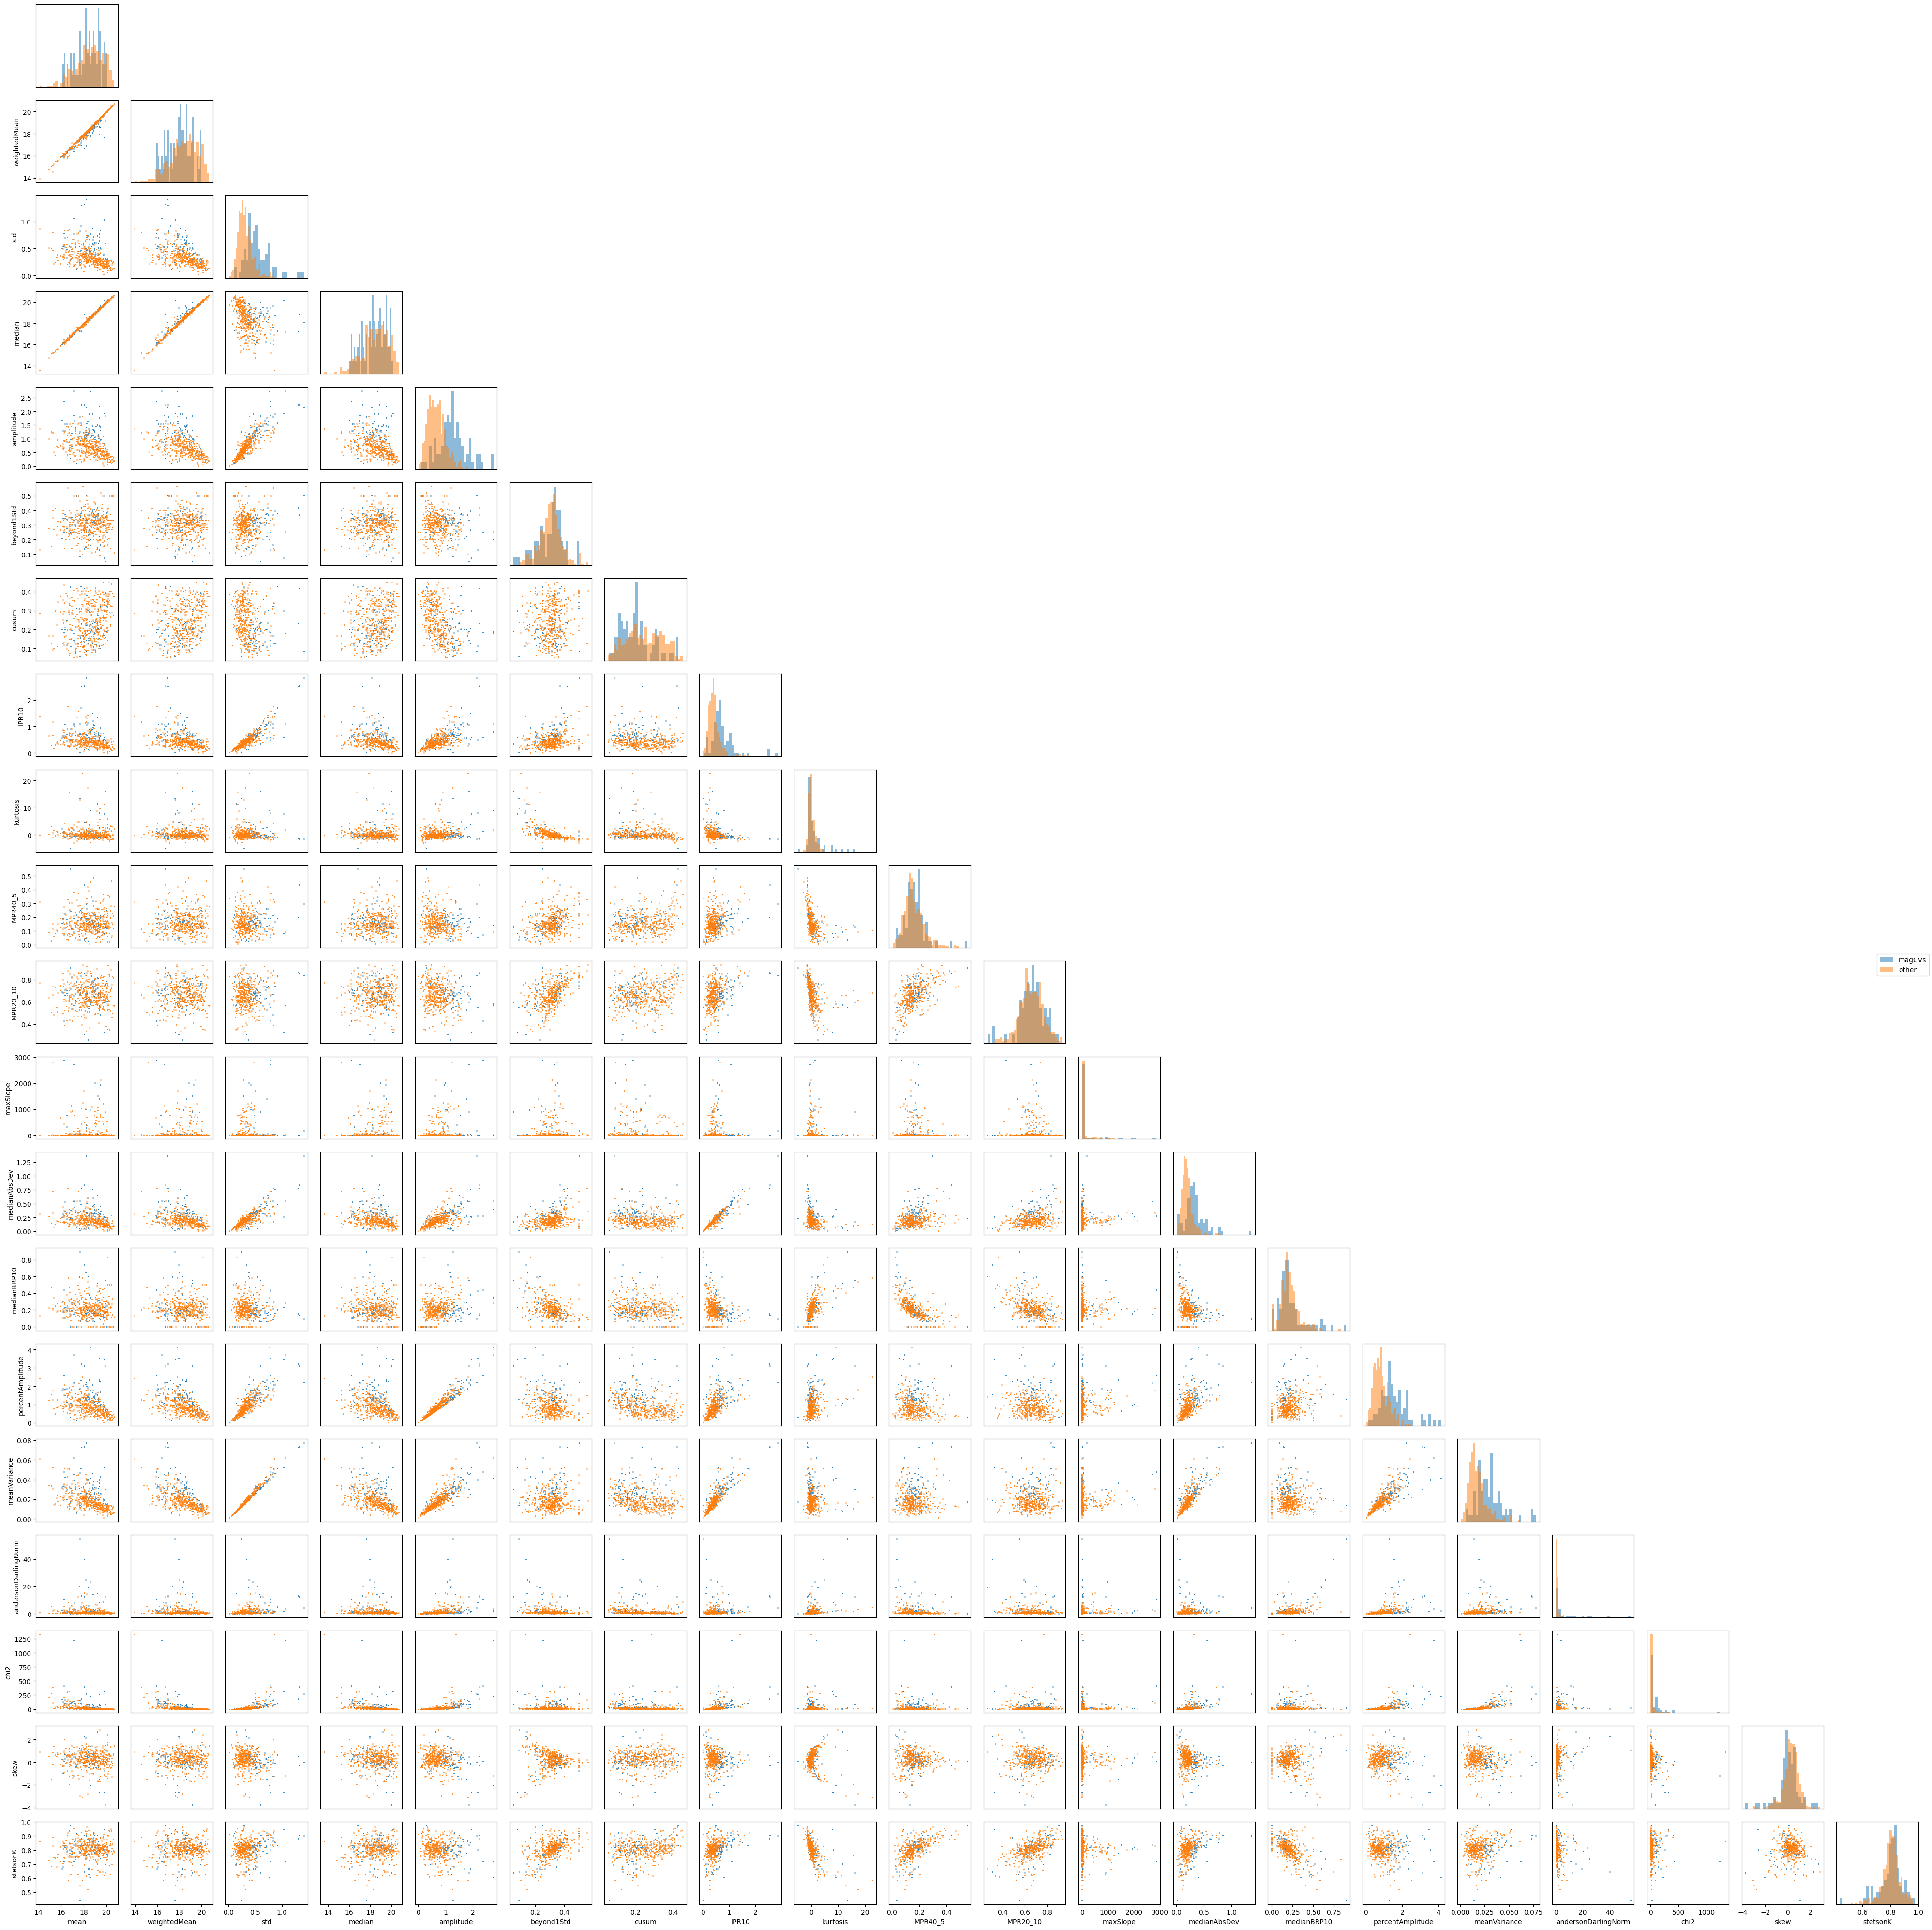

In [15]:
from magcvs_library.functions import corner_plot
# Feature names (without linear features):
feature_names = ['mean', 'weightedMean', 'std', 'median', 'amplitude', 'beyond1Std', 'cusum', 'IPR10',
                 'kurtosis', 'MPR40_5', 'MPR20_10', 'maxSlope', 'medianAbsDev', 'medianBRP10',
                 'percentAmplitude', 'meanVariance', 'andersonDarlingNorm', 'chi2', 'skew', 'stetsonK']

corner_plot(positive_g[feature_names], negative_g[feature_names], data_labels=['magCVs', 'other'], alpha=.9) # Should take less than a minute to run